### Spectral Graph Analysis 
This part used flight delay data on 2015 Jun. We created a graph using airports as nodes, and distance between airports as weights. Calculating the eigenvalues and plotting them, we noticed a jump from 4-th to 5-th eigenvalue, which implies 5 clusters in our data. So we used top 5 eigenvectors as features and did the k-means (k=5). The result was both shown spectrally and geographically. And we can see that there is connection between airport location (whether they are in Eastern US or Western US) and delay time.

In [1]:
import pandas as pd
import numpy as np
import networkx as nx
from scipy import sparse
import scipy.sparse.linalg
import matplotlib.pyplot as plt

from sklearn.cluster import KMeans
from sklearn.metrics.pairwise import pairwise_distances_argmin

In [2]:
flights = pd.read_csv('flights_new.csv')
airports = pd.read_csv('airports.csv')

In [3]:
pos_dict = {}
for i in range(len(airports)):
    pos_dict[airports.IATA_CODE[i]] = airports.LONGITUDE[i],airports.LATITUDE[i]

In [4]:
df = flights[['MONTH','ORIGIN_AIRPORT','DESTINATION_AIRPORT','DEPARTURE_DELAY','ARRIVAL_DELAY','AIR_TIME','DISTANCE']]

In [24]:
df1 = df.loc[df.MONTH==6].copy()
df2 = df1.groupby(['ORIGIN_AIRPORT','DESTINATION_AIRPORT'])['DEPARTURE_DELAY','ARRIVAL_DELAY','AIR_TIME','DISTANCE'].mean()
df2.reset_index(inplace=True)

df2['weight'] = df2.DISTANCE
df2.weight = df2.weight.clip_upper(2000)
df2.weight=(df2.weight-df2.weight.min())/(df2.weight.max()-df2.weight.min())

delta = 0.5
df2.weight = np.exp(-np.square(df2.weight)/delta)


In [25]:
G=nx.from_pandas_edgelist(df2, 'ORIGIN_AIRPORT', 'DESTINATION_AIRPORT', edge_attr='weight')

In [26]:
node_col = G.nodes
label_df = pd.DataFrame(columns=node_col).append(df2.groupby(['ORIGIN_AIRPORT'])['DEPARTURE_DELAY','ARRIVAL_DELAY'].mean().T,sort=False).T
label_df.ARRIVAL_DELAY = label_df.ARRIVAL_DELAY-10
label_df.ARRIVAL_DELAY = label_df.ARRIVAL_DELAY.clip_upper(-1*np.min(label_df.ARRIVAL_DELAY))
label_df.head()

,DEPARTURE_DELAY,ARRIVAL_DELAY
ABE,12.595216,3.050936
ATL,14.348884,-1.562118
DTW,12.056992,-2.587865
ORD,19.658550,6.241072
ABI,10.509709,0.538835


In [27]:
label_geo_df = pd.merge(label_df,airports.set_index('IATA_CODE'),left_index=True,right_index=True)

In [28]:
L = nx.normalized_laplacian_matrix(G)
e, U = sparse.linalg.eigsh(L, k=10, which='BE')

In eigenvalues we had a jump in 5-th eigenvalue, which implies that our data had 5 clusters. So in next step, we performed 5-cluster k means to find the label.

Text(0.5,1,'top 10 eigenvalue')

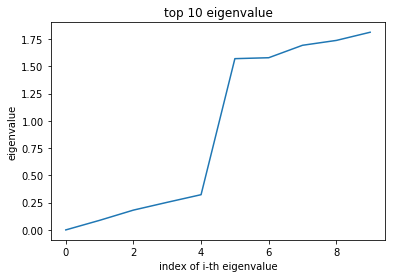

In [29]:
plt.plot(e)
plt.xlabel('index of i-th eigenvalue')
plt.ylabel('eigenvalue')
plt.title('top 10 eigenvalue')

In [30]:
# we used top 5 eigenvectors as our features
X = U[:,0:5]

k_means = KMeans(init='k-means++', n_clusters=5, n_init=10)
k_means.fit(X)

k_means_cluster_centers = np.sort(k_means.cluster_centers_, axis=0)
k_means_labels = pairwise_distances_argmin(X, k_means_cluster_centers)

(-0.02, 0.03)

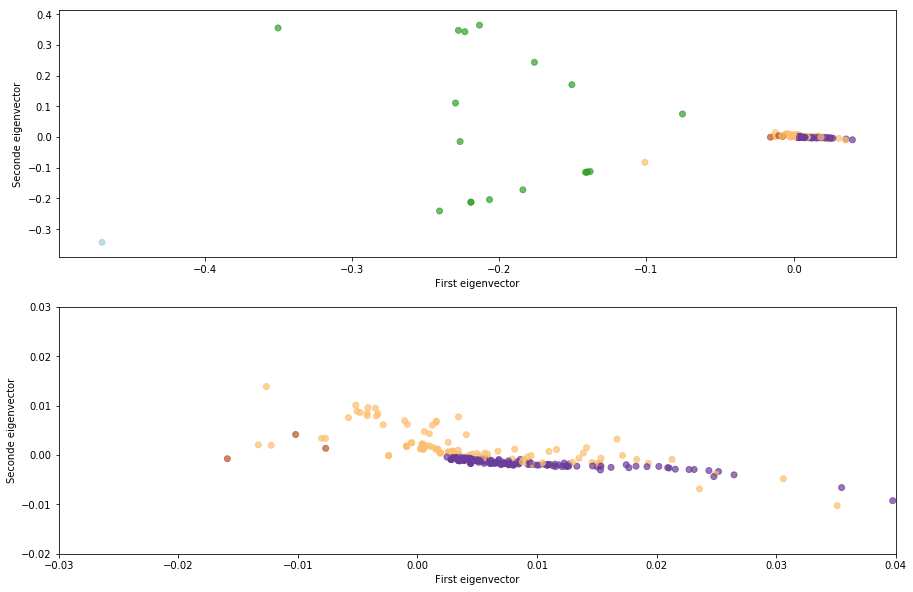

In [31]:
cmap = plt.get_cmap('Paired',5)

fig, ax = plt.subplots(2,1,figsize=(15,10))
ax[0].scatter(U[:,1],U[:,2],c=k_means_labels,alpha=0.7,cmap=cmap)
ax[0].set_xlabel('First eigenvector')
ax[0].set_ylabel('Seconde eigenvector')
#plt.colorbar()
ax[1].scatter(U[:,1],U[:,2],c=k_means_labels,alpha=0.7,cmap=cmap)
ax[1].set_xlabel('First eigenvector')
ax[1].set_ylabel('Seconde eigenvector')
ax[1].set_xlim(-0.03,0.04)
ax[1].set_ylim(-0.02,0.03)


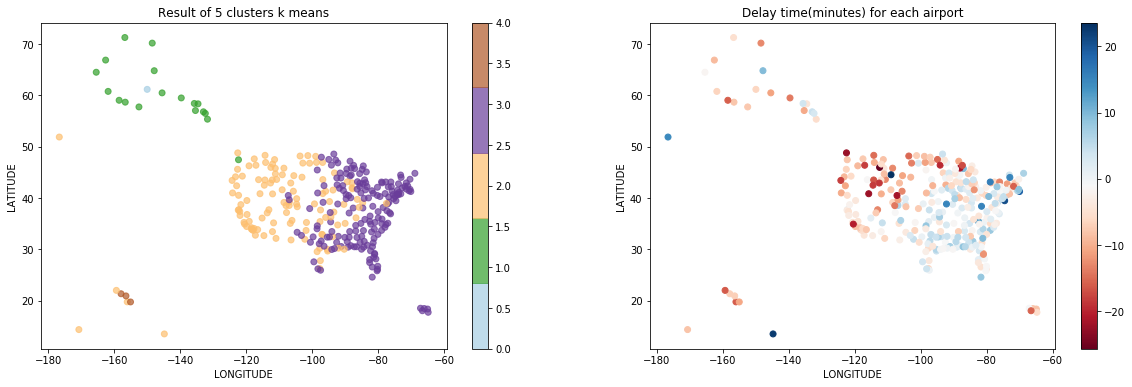

In [33]:
fig, ax = plt.subplots(1,2,figsize=(20,6))
im0 = ax[0].scatter(y=label_geo_df.LATITUDE,x=label_geo_df.LONGITUDE,
                    c=k_means_labels,cmap=cmap,alpha=0.7)
ax[0].set_ylabel('LATITUDE')
ax[0].set_xlabel('LONGITUDE')
ax[0].set_title('Result of 5 clusters k means')
#plt.colorbar()

label = label_geo_df.ARRIVAL_DELAY.copy()
label[label<=0] = -1
label[label>0] = 1
# ax[1].scatter(y=label_geo_df.LATITUDE,x=label_geo_df.LONGITUDE,c=label,cmap='Paired')
im1 = ax[1].scatter(y=label_geo_df.LATITUDE,x=label_geo_df.LONGITUDE,
                    c=label_geo_df.ARRIVAL_DELAY,cmap='RdBu')

ax[1].set_ylabel('LATITUDE')
ax[1].set_xlabel('LONGITUDE')
ax[1].set_title('Delay time(minutes) for each airport')

fig.colorbar(im0, ax=ax[0])
fig.colorbar(im1, ax=ax[1])


Finding the shortest path.

In [14]:
nx.dijkstra_path(G,source='ABE',target='ABI')

['ABE', 'ATL', 'ANC', 'DFW', 'ABI']